In [1]:
# import 
import datetime,os

import ipywidgets as widgets
from IPython.display import display

import IPython
import IPython.display
# import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import clear_output

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from math import sqrt
from numpy import concatenate
import numpy as np
import math

import pandas as pd
from pandas import DataFrame
from pandas import concat

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# import tensorflow 
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.layers import BatchNormalization

# Load the TensorBoard notebook extension.
%load_ext tensorboard


import platform
print(platform.python_version())
print(np.__version__)
print(tf.__version__)

# tf.config.list_physical_devices('GPU')

3.10.4
1.22.3
2.9.1


In [2]:
# File name and Path
cwd = os.getcwd()
path_adress = "/Import_Dataset/"

# ข้อมูล พิกัดสถานที่เเละรายชื้ออ้างอิงสถานที่ตรวจวัด
file_name_st = 'Data_lat_long_Rice research Center'
csv_file_st = cwd + path_adress + file_name_st + '.csv'

df_st = pd.read_csv(csv_file_st)
print("All low RiceCenter {} station" .format(df_st.shape[0]))

data_list_st_num = list(range(0, len(df_st)))
data_list_st_name = []
data_list_st_name = df_st['nameEng'].values.tolist()
data_list_st_lat = df_st['Latitude'].values.tolist()
data_list_st_long = df_st['Longitude'].values.tolist()

#################-- Moving Averag data --#################
def mavr_dataset(frames_sma,rolling_num,our_rate):    
    h_name = list(frames_sma)
    frames_sma['mirid bug'] = frames_sma['mirid bug'].rolling(rolling_num, min_periods=1).sum().round(1)
    frames_sma['bph'] = frames_sma['bph'].rolling(rolling_num, min_periods=1).sum().round(1)
    # frames_sma['mirid bug'] = frames_sma['mirid bug'].rolling(rolling_num, min_periods=1).mean().round(1)
    # frames_sma['bph'] = frames_sma['bph'].rolling(rolling_num, min_periods=1).mean().round(1)
    for i in range(7,14):
        frames_sma[h_name[i]] = frames_sma[h_name[i]].rolling(rolling_num, min_periods=1).mean().round(1)

    constant_subset = frames_sma[::our_rate] 
    return constant_subset

#################-- creat_dataset  --#################
def creat_dataset(st_BPH = 'ALL', y_1='2015', y_2='2019', m_avr='ALL-DAY'):
    for i in range(len(data_list_st_num)):
        st = i
        file_name = df_st['nameEng'][data_list_st_num[st]]
        name_input = file_name
        name_locals = 'stN_' + file_name

        # File name and Path
        csv_file = cwd + path_adress + name_input + '.csv'
        # index_col=0 , index_col=None
        dataset = pd.read_csv(csv_file, header=0,
                              index_col=0, encoding="TIS-620")

        if m_avr == '3-DAY':
            locals()[name_locals] = mavr_dataset(dataset,3,3)
        elif m_avr == '7-DAY':
            locals()[name_locals] = mavr_dataset(dataset,7,7)
        else :
            locals()[name_locals] = mavr_dataset(dataset,7,1)
            # print(f'Dataframe name_station: {st+1 , name_input}')
        print('wait......')
        del dataset
        clear_output(wait=True)

    date_start = y_1 + '-01' + '-01'
    date_stop = y_2 + '-12' + '-31'

#---------------------------------------------------------------------------------------------------------------------------------------------------#
    if st_BPH != 'ALL' :
        # file_name = df_st['nameEng'][data_list_st_num[st_BPH]]
        file_name = st_BPH
        locals_input = 'stN_' + file_name
        print(locals_input)
        dataset_st = locals()[locals_input].loc[date_start:date_stop]
        frames_st = dataset_st
    else:
        m = 0
        for j in range(len(data_list_st_num)):
            # for j in range(df_st.shape[0]):
            # file_name = df_st['nameEng'][j]
            file_name = df_st['nameEng'][data_list_st_num[j]]
            locals_input = 'stN_' + file_name
            print(locals_input)
            dataset_st = locals()[locals_input].loc[date_start:date_stop]
            clear_output(wait=True)
            if m == 0:
                frames_st = dataset_st
                m = m+1
                print(m)
            else:
                frames_st = [frames_st, dataset_st]
                frames_st = pd.concat(frames_st)

    # dataset    
    frames = frames_st
    return frames
#---------------------------------------------------------------------------------------------------------------------------------------------------#

#################-- Drop Colum  --#################
def drop_col(df_drop,drop = ['address']):
    for j in range(len(drop)):
        df_drop = df_drop.drop(drop[j], axis=1)
    return df_drop

#################--      Plot        --#################
def plot_data(frames_train,plot_cols,df_name,start='2015',end='2017'):
    #ตรวจสอบข้อมูล dataset 
    
    df_plot = frames_train[plot_cols].loc[start:end]
    plt.figure()    
    # df_plot.plot(lw=1,grid=True,figsize=(13,30),subplots=True)
    # df_plot.plot(lw=1,grid=True,subplots=True)
    # df_plot.plot(marker='.',grid=True,linestyle = 'solid',subplots=True)
    df_plot.plot(marker='.',grid=True,linestyle = 'solid')
    plt.xlabel('Date time-'+ df_name)
    plt.legend()
    # plt.show()   

#################--                  --#################

All low RiceCenter 34 station


#### LSTM model

In [3]:
#################-- convert series to supervised learning --#################
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

#################--          data_preprocess        --#################
def data_preprocess(data_frames,n_day,n_out):
      values_df = data_frames.values    #ตัด header กับ idx ออก เป็น array matrix
      n_features = data_frames.shape[1]
      # print(n_features)
      
      # ensure all data is float
      values = values_df.astype('float32')
      # normalize features
      scaler = MinMaxScaler(feature_range=(0, 1))
      scaled = scaler.fit_transform(values)

      # frame as supervised learning
      reframed = series_to_supervised(scaled, n_day, n_out)
      # print(reframed.shape)
      # print(reframed.head())

      # datasets
      values = reframed.values

      #input 
      n_obs = n_day * n_features
      dataset_X, dataset_y = values[:, :n_obs], values[:, -1]
      # print(dataset_X.shape, len(dataset_X), dataset_y.shape) 

      # reshape input to be 3D [samples, timesteps, features]
      dataset_X = dataset_X.reshape((dataset_X.shape[0], n_day, n_features))
      # print(dataset_X.shape, dataset_y.shape)

      return dataset_X,dataset_y
       
#################--           create_model           --#################
def create_model(units,shape_1,shape_2,activation = 'relu'):
      return tf.keras.models.Sequential([
                  # Shape [batch, time, features] => [batch, time, lstm_units]
                  keras.layers.LSTM(units=units, input_shape=(shape_1, shape_2),activation=activation),
                  # keras.BatchNormalization(),
                  keras.layers.Dense(units=1)
            ])            
 
#################--           train_model           --################# 

# Save checkpoints during training
checkpoint_path = "./Export_lstm/" + "last_checkpoints/" +'lstm_ckpt'+'/'+"cp-{epoch:04d}.ckpt"
checkpoint_dir_new = os.path.dirname(checkpoint_path)
# print(checkpoint_dir_new)

def train_model(model,train_x, train_y,val_x, val_y,Epochs,batch_size,optimizer = 0.0001,loss_input = 'mae',metrics_input = 'accuracy'):
      print("train_model......")
      Optimizer = tf.keras.optimizers.Adam(optimizer)
      model.compile(Optimizer, loss=loss_input, metrics= metrics_input)

      time_save = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
      logdir = os.path.join("logs", time_save)
      tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

      # Create a callback that saves the model's weights every 5 epochs
      cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,verbose=1,save_weights_only=True,save_freq="epoch",period=100)
      
      training_history =  model.fit(train_x, train_y, 
                  epochs=Epochs, 
                  batch_size=batch_size, 
                  validation_data=(val_x, val_y), 
                  verbose=1, 
                  # callbacks=[cp_callback,es_callback], 
                  # callbacks=[cp_callback],
                  callbacks=[tensorboard_callback,cp_callback])
                  # shuffle=False)
      return training_history,model,time_save

#################--           open TensorBoard          --#################   
def displaytensor():
      %tensorboard --logdir logs --port=6006
      # from tensorboard import notebook
      # notebook.list() # View open TensorBoard instances
      # notebook.display(port=6006, height=1000) 
      import webbrowser
      # generate an URL
      url = 'http://localhost:6006/'
      webbrowser.open(url)
      
# Function to convert  
def listToString(s): 
    # initialize an empty string
    str = " "     
    # return string  
    return (str.join(s))

def StringTolist(string):
    li = list(string.split(" "))
    return li
    
#################--           Save model          --#################  
def save_model(name_model = "sut_rice_model_1"):
      print('save')
      ## Set Name and Time ## Make folder
      Export_folder_name = "./Export_lstm/model/"
      
      newfolder_name = time_out+"_"+name_model
      path_newfolder = Export_folder_name
      path_newfolder_save = os.path.join(path_newfolder, newfolder_name)
      try: 
            os.mkdir(path_newfolder_save) 
      except OSError as error: 
            print(error)  

      print("Directory '% s' created" % path_newfolder_save)
      Export_folder_name = path_newfolder_save + '/'

      ## Save model
      model_name = "model_lstm"
      model_file = Export_folder_name + model_name
      model_out.save(model_file)

      # save history
      history_name = "hist_lstm.npy"
      history_file = Export_folder_name + history_name
      np.save(history_file,history_out.history)
      
      ## save discription training data
      txt_name = 'Training_model_data_discription.txt'
      filepath_save_txt = Export_folder_name + txt_name
      f = open(filepath_save_txt, "a")

      f.write("Model : "+name_model)
      f.write('\n\n')
      lines_2 = ['station :',dropdown_name_st.value]
      f.write('\t'.join(lines_2))
      f.write('\n')
      lines_3 = ['Year-train :',dropdown_year_train1.value+'-'+dropdown_year_train2.value]
      f.write('\t'.join(lines_3))
      f.write('\n')
      lines_4 = ['Year-val :',dropdown_year_val1.value+'-'+dropdown_year_val2.value]
      f.write('\t'.join(lines_4))
      f.write('\n')
      lines_5 = ['features num :',str(len(selected_data))]
      f.write('\t'.join(lines_5))
      f.write('\n')
      lines_6 = ['features drop :',listToString(selected_data)]
      f.write('\t'.join(lines_6))
      f.write('\n')
      lines_7 = ['Sampling :',dropdown_sampling_data.value]
      f.write('\t'.join(lines_7))
      f.write('\n')
      lines_8 = ['time_lag :',str(Box_nday.value)]  
      f.write('\t'.join(lines_8))
      f.write('\n')
      lines_9 = ['time_forecast :',str(Box_nout.value)]
      f.write('\t'.join(lines_9))
      f.write('\n')
      lines_10 = ['data Model :','Epochs:',str(Slider_Epochs.value),'batch_size:',str(Slider_batch_size.value),'Units:',str(Box_Units.value),'activation:',dropdown_activation.value,'loss:',dropdown_loss.value]  
      f.write('\t'.join(lines_10))
      f.write('\n')
      lines_11 = ['performance :','loss:', str(round(history_out.history['loss'][-1],5)),'accuracy:', str(round(history_out.history['accuracy'][-1],5)),'val loss:', str(round(history_out.history['val_loss'][-1],5)),'val accuracy:', str(round(history_out.history['val_accuracy'][-1],5))]  
      f.write('\t'.join(lines_11))
      f.close()




In [201]:
#################-- Dashboard --#################

ALL = 'ALL'
def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, ALL)
    return unique

#################-- DataFrame station --#################
output_df_st = widgets.Output()
def dropdown_station_eventhandler(change):
    output_df_st.clear_output()
    with output_df_st:  
        if (change.new == ALL):
            display(df_st)
        else:
            display(df_st[df_st.nameEng == change.new])

#################-- DataFrame station --#################
output_df_st_predict = widgets.Output()
def dropdown_station_predict_eventhandler(change):
    output_df_st_predict.clear_output()
    with output_df_st_predict:  
        if (change.new == ALL):
            display(df_st)
        else:
            display(df_st[df_st.nameEng == change.new])


#################-- select sampling --#################
def dropdown_sampling_eventhandler(change):
    return dropdown_sampling_data

#################-- select year train --#################
def dropdown_year_t1_eventhandler(change):
    return dropdown_year_train1
def dropdown_year_t2_eventhandler(change):
    return dropdown_year_train2
def dropdown_year_v1_eventhandler(change):
    return dropdown_year_val1
def dropdown_year_v2_eventhandler(change):
    return dropdown_year_val2
def dropdown_year_ts1_eventhandler(change):
    return dropdown_year_test1
def dropdown_year_ts2_eventhandler(change):
    return dropdown_year_test2

#################-- select model --#################
def Slider_Epochs_eventhandler(change):
    return Slider_Epochs
def Slider_batch_size_eventhandler(change):
    return Slider_batch_size
def Box_Units_eventhandler(change):
    return Box_Units
def Box_Optimizer_eventhandler(change):
    return Box_Optimizer
def dropdown_activation_eventhandler(change):
    return dropdown_activation
def dropdown_loss_eventhandler(change):
    return dropdown_loss
def Box_nday_eventhandler(change):
    return Box_nday
def Box_nout_eventhandler(change):
    return Box_nout

#################-- select predict --#################
def dropdown_start_date_eventhandler(change):
    return start_date
def dropdown_end_date_eventhandler(change):
    return end_date
def dropdown_file_eventhandler(change):
    return file

#################-- load data  --#################
output_df_train = widgets.Output()
output_df_val = widgets.Output()
output_df_test = widgets.Output()
output_df_col = widgets.Output()
def clicked_load(b):
   
    global df_out_train
    global df_out_val
    global df_out_test
    global selected_data
    output_df_train.clear_output()
    output_df_val.clear_output()
    output_df_test.clear_output()
    output_df_col.clear_output()
    with output_df_train:
        df_out_train = creat_dataset(dropdown_name_st.value,dropdown_year_train1.value,dropdown_year_train2.value,dropdown_sampling_data.value)
        display(df_out_train)
        # display(creat_dataset(dropdown_name_st.value,dropdown_year_train1.value,dropdown_year_train2.value,dropdown_sampling_data.value))
    with output_df_val:
        df_out_val = creat_dataset(dropdown_name_st.value,dropdown_year_val1.value,dropdown_year_val2.value,dropdown_sampling_data.value)
        display(df_out_val)
        # display(creat_dataset(dropdown_name_st.value,dropdown_year_val1.value,dropdown_year_val2.value,dropdown_sampling_data.value))
    with output_df_test:
        df_out_test = creat_dataset(dropdown_name_st.value,dropdown_year_test1.value,dropdown_year_test2.value,dropdown_sampling_data.value)
        display(df_out_test)
        # display(creat_dataset(dropdown_name_st.value,dropdown_year_test1.value,dropdown_year_test2.value,dropdown_sampling_data.value))
    with output_df_col:
        checkbox_objects = []
        # global selected_data
        data = set(chek_list(df_out_train))    
        names = []
        for key in data:
                checkbox_objects.append(widgets.Checkbox(value=False, description=key))
                names.append(key)
 
        arg_dict = {names[i]: checkbox for i, checkbox in enumerate(checkbox_objects)}
        ui = widgets.HBox(children=checkbox_objects)
        display(ui)
             
        selected_data = []
        def select_data(**kwargs):
            selected_data.clear()
            for key in kwargs:
                if kwargs[key] is True:
                    selected_data.append(key)
            print(selected_data)

        widgets.interactive_output(select_data, arg_dict)
    
    return df_out_train,df_out_val,df_out_test

def chek_list(df_ch):
        data_col = set(df_ch.columns)    
        return data_col

#################-- Export data  --#################
df_train = widgets.Output()
df_val = widgets.Output()
df_test = widgets.Output()
def clicked_export(b):
    df_train.clear_output()
    df_val.clear_output()
    df_test.clear_output()
    global frames_train
    global frames_val
    global frames_test
    with df_train:
        frames_train = drop_col(df_out_train,selected_data) 
        display(frames_train)
    with df_val:
        frames_val = drop_col(df_out_val,selected_data) 
        display(frames_val)  
    with df_test:
        frames_test = drop_col(df_out_test,selected_data) 
        display(frames_test)     


#################-- create_model  --#################
output_create_model = widgets.Output()
def clicked_model(b):
    output_create_model.clear_output()
    global model_in
    global train_X
    global train_Y
    global val_X
    global val_Y
    
    
    with output_create_model:
        train_X, train_Y = data_preprocess(frames_train,Box_nday.value,Box_nout.value)
        val_X,val_Y = data_preprocess(frames_val,Box_nday.value,Box_nout.value)              
        model_in = create_model(Box_Units.value,train_X.shape[1],train_X.shape[2],dropdown_activation.value)
        clear_output(wait=True) 
        print(model_in.summary())
        print(train_X.shape)  
        print(train_Y.shape) 
        
#################-- fit_model  --#################
output_fit_model = widgets.Output()   
def clicked_train(b):
    output_fit_model.clear_output()
    global history_out,model_out,time_out
       
    with output_fit_model:
        # fit network
        # (train_x, train_y,val_x, val_y,Epochs,batch_size,optimi = 0.0001,loss_input = 'mae',metrics_input = 'accuracy'):
        history_out,model_out,time_out = train_model(model_in,train_X, train_Y,val_X, val_Y,Slider_Epochs.value,Slider_batch_size.value,
                                Box_Optimizer.value,dropdown_loss.value)
        print("Average test loss: ", np.average(history_out.history['loss']))
        
      
 #################-- tensorboard display  --#################
output_tensorboard = widgets.Output()      
def clicked_tensor(b):
    output_tensorboard.clear_output()
    with output_tensorboard:
         displaytensor()

#################-- load predict  --#################


#################-- Plot data  --#################
output_df_plot = widgets.Output()


#################----------------------------- DashBoard  ----------------------------------#################
dropdown_name_st = widgets.Dropdown(options = unique_sorted_values_plus_ALL(df_st.nameEng),description='station :')
dropdown_name_st_predict = widgets.Dropdown(options = unique_sorted_values_plus_ALL(df_st.nameEng),description='station :')
dropdown_sampling_data = widgets.Dropdown(options = ['All-DAY','3-DAY','7-DAY'],valure = 'All-DAY',description='Sampling :')
dropdown_year_train1 = widgets.Dropdown(options = ['2015','2016','2017','2018','2019','2020'],description='Year-train :')
dropdown_year_train2 = widgets.Dropdown(options = ['2015','2016','2017','2018','2019','2020'],value = '2017')
dropdown_year_val1 = widgets.Dropdown(options = ['2015','2016','2017','2018','2019','2020'],value = '2018',description='Year-val :')
dropdown_year_val2 = widgets.Dropdown(options = ['2015','2016','2017','2018','2019','2020'],value = '2018')
dropdown_year_test1 = widgets.Dropdown(options = ['2015','2016','2017','2018','2019','2020'],value = '2019',description='Year-test :')
dropdown_year_test2 = widgets.Dropdown(options = ['2015','2016','2017','2018','2019','2020'],value = '2019')

button_download = widgets.Button(description='load data',disabled=False,button_style='success',tooltip='Click me',icon='check')
button_export = widgets.Button(description='export dataset',disabled=False,button_style='success',tooltip='Click me',icon='check')
button_model = widgets.Button(description='create_model',disabled=False,button_style='success',tooltip='Click me',icon='check')
button_train = widgets.Button(description='train_model',disabled=False,button_style='success',tooltip='Click me',icon='check')
button_tensorboard = widgets.Button(description='tensorboard',disabled=False,button_style='success',tooltip='Click me',icon='check')

Slider_Epochs = widgets.IntSlider(value=10,min=10,max=5000,step=10,description='Epochs :',disabled=False,continuous_update=False,orientation='horizontal', readout=True,readout_format='d')
Slider_batch_size = widgets.IntSlider(value=128,min=16,max=256,step=8,description='Batch_size :',disabled=False,continuous_update=False,orientation='horizontal', readout=True,readout_format='d')
Box_Units = widgets.IntText(value=50,description='units :',disabled=False)
Box_Optimizer = widgets.FloatText(value=0.0001,step=0.0001,description='Optimizer :',disabled=False)
dropdown_activation = widgets.Dropdown(options = ['relu','elu','sigmoid','tanh'],valure = 'elu',description='activation :')
dropdown_loss = widgets.Dropdown(options = ['mae','mae'],valure = 'mae',description='loss :')
Box_nday = widgets.IntText(value=7,description='n-day :',disabled=False)
Box_nout = widgets.IntText(value=1,description='n-out :',disabled=False)

start_date = widgets.DatePicker(description='Start Date',disabled=False)
end_date = widgets.DatePicker(description='End Date',disabled=False)
file = widgets.FileUpload(accept='.txt', multiple=False)

button_download.on_click(clicked_load)
button_export.on_click(clicked_export)
button_model.on_click(clicked_model)
button_train.on_click(clicked_train)
button_tensorboard.on_click(clicked_tensor)

dropdown_name_st.observe(dropdown_station_eventhandler, names='value')
dropdown_name_st_predict.observe(dropdown_station_predict_eventhandler, names='value')
dropdown_sampling_data.observe(dropdown_sampling_eventhandler, names='value')
dropdown_year_train1.observe(dropdown_year_t1_eventhandler, names='value')
dropdown_year_train2.observe(dropdown_year_t2_eventhandler, names='value')
dropdown_year_val1.observe(dropdown_year_v1_eventhandler, names='value')
dropdown_year_val2.observe(dropdown_year_v2_eventhandler, names='value')
dropdown_year_test1.observe(dropdown_year_ts1_eventhandler, names='value')
dropdown_year_test2.observe(dropdown_year_ts2_eventhandler, names='value')
Slider_Epochs.observe(Slider_Epochs_eventhandler, names='value')
Slider_batch_size.observe(Slider_batch_size_eventhandler, names='value')
Box_Units.observe(Box_Units_eventhandler, names='value')
Box_Optimizer.observe(Box_Optimizer_eventhandler, names='value')
dropdown_activation.observe(dropdown_activation_eventhandler, names='value')
dropdown_loss.observe(dropdown_loss_eventhandler, names='value')
Box_nday.observe(Box_nday_eventhandler, names='value')
Box_nout.observe(Box_nout_eventhandler, names='value')
start_date.observe(dropdown_start_date_eventhandler, names='values')
end_date.observe(dropdown_end_date_eventhandler, names='values')
file.observe(dropdown_file_eventhandler, names='values')

item_layout = widgets.Layout(margin='0 0 15px 0')

input_widgets_row1 = widgets.HBox([dropdown_name_st,dropdown_year_train1,dropdown_year_train2,dropdown_year_val1,dropdown_year_val2,dropdown_year_test1,dropdown_year_test2],layout = item_layout)
input_widgets_row2 = widgets.HBox([dropdown_sampling_data,button_download,button_export],layout = item_layout)
input_widgets_row3 = widgets.HBox([Slider_Epochs,Slider_batch_size,Box_Units,Box_Optimizer],layout = item_layout)
input_widgets_row4 = widgets.HBox([dropdown_activation,dropdown_loss,Box_nday,Box_nout],layout = item_layout)
input_widgets_row5 = widgets.HBox([button_model,button_train,button_tensorboard])

tab_dataset = widgets.Tab([output_df_st,output_df_train,output_df_val,output_df_test,output_df_col,df_train,df_val,df_test])
tab_dataset.set_title(0, 'Dataset station')
tab_dataset.set_title(1, 'train-data')
tab_dataset.set_title(2, 'validation-data')
tab_dataset.set_title(3, 'test-data')
tab_dataset.set_title(4, 'Drop-data')
tab_dataset.set_title(5, 'Dataset-train')
tab_dataset.set_title(6, 'Dataset-validation')
tab_dataset.set_title(7, 'Dataset-test')
dashboard_dataset = widgets.VBox([input_widgets_row1,input_widgets_row2])
display(dashboard_dataset)
display(tab_dataset)

dashboard_model = widgets.VBox([input_widgets_row3,input_widgets_row4,input_widgets_row5])
tab_model = widgets.Tab([output_create_model,output_fit_model,output_tensorboard])
tab_model.set_title(0,'model.summary')
tab_model.set_title(1,'model_fit')
tab_model.set_title(2,'tensorboard')
display(dashboard_model)
display(tab_model)

input_widgets_row6 = widgets.HBox([dropdown_name_st_predict, start_date, end_date])
input_widgets_row7 = widgets.HBox([file])

dashboard_predict = widgets.VBox([input_widgets_row6,input_widgets_row7])
tab_predict = widgets.Tab([output_df_st_predict])
tab_predict.set_title(0,'Dataset station')
display(dashboard_predict)
display(tab_predict)


In [ ]:
filename_model = "sut_rice_model_8"
save_model(filename_model)

In [ ]:
test_X, test_Y = data_preprocess(frames_test,Box_nday.value,Box_nout.value)
# evaluate the model
loss, acc = model_out.evaluate(test_X, test_Y, verbose=2)
print('test_Accuracy : ', round(acc,5))
print('test_loss : ', round(loss,5))

In [ ]:
print("parameter creat model : Epochs : %d,  batch_size : %d, n-day : %d, n-out : %d" % (Slider_Epochs.value, Slider_batch_size.value, Box_nday.value, Box_nout.value))
print("parameter Model Fit : Units : %d,  activation : %s," % (Box_Units.value, dropdown_activation.value))
print("num drop: %d" %(len(selected_data)))
# print("loss: ", round(history_out.history['loss'][-1],5))
# print("accuracy: ", round(history_out.history['accuracy'][-1],5))
# print("val loss: ", round(history_out.history['val_loss'][-1],5))
# print("val accuracy: ", round(history_out.history['val_accuracy'][-1],5))

In [106]:

display(file)

FileUpload(value={}, description='Upload')

In [135]:
file.value['Training_model_data_discription.txt']
file_txt = str(list(file.value)[0])

In [151]:
dict = file.value[file_txt]
string_data = str(dict['content'])
li = list(string_data.split("\\n"))

line_0_model_name = (li[0].split(":"))[1]
print(line_0_model_name)
line_4_drop = (li[4].split(":"))[1]
print(line_4_drop)
line_5_sampling = (li[5].split(":"))[1]
print(line_5_sampling)
line_6_time_lag = (li[6].split(":"))[1]
print(line_6_time_lag)
line_7_time_forecast = (li[7].split(":"))[1]
print(line_7_time_forecast)

20220730-025658_sut_rice_model_1
address,year
All-DAY
7
1


In [197]:
date_start = str(start_date.value)
date_stop = str(end_date.value)
print(date_start)
print(date_stop)

2015-01-01
2015-03-25


In [198]:
df_out_predict = creat_dataset(dropdown_name_st_predict.value,str(start_date.value)[0:4],str(end_date.value)[0:4],line_5_sampling)
# df_out_predict.head()
frames_predict = drop_col(df_out_predict,list(line_4_drop.split(","))).loc[date_start:date_stop] 
# frames_predict.head()

stN_Chachoengsao Rice research Center


In [199]:
n_day = int(line_6_time_lag)
n_out = int(line_7_time_forecast)

values_df = frames_predict.values    #ตัด header กับ idx ออก เป็น array matrix
n_features = frames_predict.shape[1]
# print(n_features)

# ensure all data is float
values = values_df.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, n_day, n_out)
# print(reframed.shape)
# print(reframed.head())

# datasets
values = reframed.values

#input 
n_obs = n_day * n_features
dataset_X, dataset_y = values[:, :n_obs], values[:, -1]
# print(dataset_X.shape, len(dataset_X), dataset_y.shape) 

# reshape input to be 3D [samples, timesteps, features]
dataset_X = dataset_X.reshape((dataset_X.shape[0], n_day, n_features))
# print(dataset_X.shape, dataset_y.shape)

In [181]:
Export_folder_name = "./Export_lstm/model/"
model_name = Export_folder_name+line_0_model_name+"/model_lstm"
print(model_name)
## Load model
model_loaded = tf.keras.models.load_model(model_name)
# model_loaded.summary()

./Export_lstm/model/20220730-025658_sut_rice_model_1/model_lstm


3/3 [==============================] - 0s 2ms/step
Test RMSE: 3.113


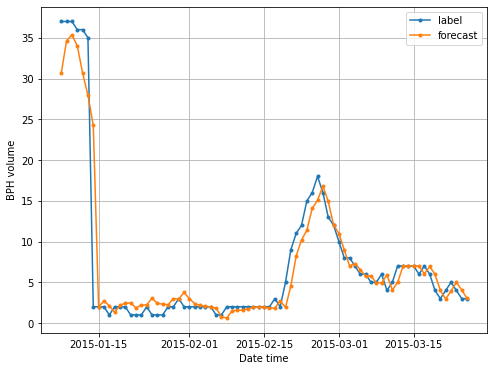

In [200]:
# # make a prediction
yhat = model_loaded.predict(dataset_X)
test_X_reshape = dataset_X.reshape((dataset_X.shape[0], n_day*n_features))
    
# invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, -29:]), axis=1)
inv_yhat = concatenate((test_X_reshape[:, :(n_features-1)], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y_reshape = dataset_y.reshape((len(dataset_y), 1))
# inv_y = concatenate((test_y, test_X[:, -29:]), axis=1)
inv_y = concatenate((test_X_reshape[:, :(n_features-1)], test_y_reshape), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

forecast_data = (abs(inv_yhat[:])) 
label_data =  inv_y[:]

# calculate RMSE
rmse = sqrt(mean_squared_error(label_data,forecast_data))

print('Test RMSE: %.3f' % rmse)

# df = frames_test.loc[date_start:date_stop].reset_index()
df = frames_predict.reset_index()
date_time_predict = pd.to_datetime(df.pop('date'))

from matplotlib import pyplot as plt
def plot_Perfor():
      plt.figure()
      plt.plot(date_time_predict[n_day+n_out-1:],label_data,label='label',marker='.')
      plt.plot(date_time_predict[n_day+n_out-1:],forecast_data,label='forecast',marker='.')

      plt.ylabel('BPH volume')
      plt.xlabel('Date time')
      # plt.title(file_name +'  RMSE: %.3f' % rmse)
      plt.legend()
      plt.grid(True)
      # plt.show()

plot_Perfor()

In [ ]:
df_plot = frames_test['bph'].loc[date_start:date_stop]
df_plot

In [ ]:
name_plot = 'data test'
cols = ['mirid bug', 'bph']
date_start = '2015-01-01'
date_stop = '2017-12-31'
plot_data(frames_train,cols,name_plot,date_start,date_stop)





In [ ]:
selmul = widgets.SelectMultiple(
    options=['Apples', 'Oranges', 'Pears'],
    value=['Oranges'],
    #rows=10,
    description='Fruits',
    disabled=False
)
display(selmul)


In [ ]:
# load history
# historytt=np.load(history_file,allow_pickle='TRUE').item()
# def plot_loss(history):
#     plt.figure()
#     plt.plot(history['loss'], label='train')
#     plt.plot(history['val_loss'], label='val')
#     plt.xlabel('Epoch')
#     plt.ylabel('Error')
#     plt.legend()
#     plt.grid(True)
#     plt.show()
# plot_loss(historytt)